# V = 2, C = 2, Mixture of two independent bivariate Gaussians
## Note: Reduced identifiability due to increased standard deviation

Requires RainDancesVI package https://prasanthcakewalk.gitlab.io/raindancesvi/ (tested with version 0.1.0)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as klayers

import raindancesvi as rd6
from raindancesvi import inclass_utils

In [3]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'text.usetex': True, 'text.latex.preview': True})

def figname(string):
    fig_dir = 'figures/V2_C2_two_gaussians_unidentifiable_2'
    fig_name_prefix = 'two_gaussians_unidentifiable_2_'
    return f'{fig_dir}/{fig_name_prefix}{string}'

## Data generation & true classifier definition:

In [4]:
rng_seed = 0
rng = np.random.Generator(np.random.PCG64(rng_seed))

x_input_shape, y_input_shape = 1, 1
comp_1_params = {'x_args': {'loc': -1, 'scale': 2.5}, 'y_args': {'loc': -1, 'scale': 2.5}}
comp_2_params = {'x_args': {'loc': 1, 'scale': 2.5}, 'y_args': {'loc': 1, 'scale': 2.5}}
w_1, w_2 = 0.4, 0.6

comp_1_x_pdf = lambda x: scipy.stats.norm.pdf(x, **comp_1_params['x_args'])
comp_2_x_pdf = lambda x: scipy.stats.norm.pdf(x, **comp_2_params['x_args'])
comp_1_y_pdf = lambda y: scipy.stats.norm.pdf(y, **comp_1_params['y_args'])
comp_2_y_pdf = lambda y: scipy.stats.norm.pdf(y, **comp_2_params['y_args'])

x_pdf = lambda x: w_1 * comp_1_x_pdf(x) + w_2 * comp_2_x_pdf(x)
y_pdf = lambda y: w_1 * comp_1_y_pdf(y) + w_2 * comp_2_y_pdf(y)
xy_pdf = lambda x, y: w_1 * comp_1_x_pdf(x) * comp_1_y_pdf(y) + w_2 * comp_2_x_pdf(x) * comp_2_y_pdf(y)

# Data generation ######################
N = 10**5
N_1, N_2 = rng.multinomial(N, [w_1, w_2])

comp_1_x = rng.normal(size=N_1, **comp_1_params['x_args'])
comp_1_y = rng.normal(size=N_1, **comp_1_params['y_args'])
comp_2_x = rng.normal(size=N_2, **comp_2_params['x_args'])
comp_2_y = rng.normal(size=N_2, **comp_2_params['y_args'])

sample_x = np.concatenate([comp_1_x, comp_2_x])
sample_y = np.concatenate([comp_1_y, comp_2_y])

shuffle = rng.permutation(N)
sample_x = sample_x[shuffle]
sample_y = sample_y[shuffle]
########################################

# True classifier definition ###########
comp_1_classify_x = lambda x: w_1 * comp_1_x_pdf(x) / x_pdf(x)
comp_2_classify_x = lambda x: w_2 * comp_2_x_pdf(x) / x_pdf(x)
comp_1_classify_y = lambda y: w_1 * comp_1_y_pdf(y) / y_pdf(y)
comp_2_classify_y = lambda y: w_2 * comp_2_y_pdf(y) / y_pdf(y)

comp_1_classify_xy = lambda x, y: w_1 * comp_1_x_pdf(x) * comp_1_y_pdf(y) / xy_pdf(x, y)
comp_2_classify_xy = lambda x, y: w_2 * comp_2_x_pdf(x) * comp_2_y_pdf(y) / xy_pdf(x, y)

def true_classifiers(inputs):
    x, y = inputs
    components = 2
    ans = np.zeros((len(x), 2, components))
    ans[:,0,0] = comp_1_classify_x(x)
    ans[:,1,0] = comp_1_classify_y(y)
    ans[:,0,1] = comp_2_classify_x(x)
    ans[:,1,1] = comp_2_classify_y(y)
    
    return ans

def true_aggregate_classifier(inputs):
    x, y = inputs
    components = 2
    ans = np.zeros((len(x), components))
    ans[:,0] = comp_1_classify_xy(x, y)
    ans[:,1] = comp_2_classify_xy(x, y)
    
    return ans
########################################

## Data visualization:

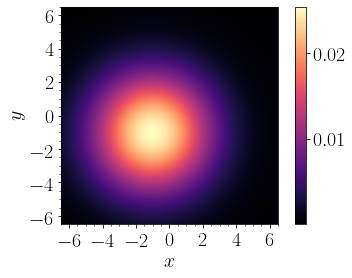

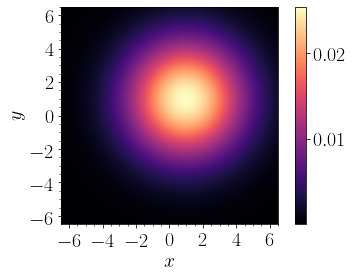

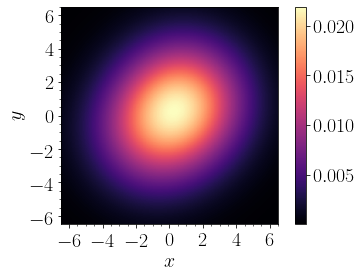

In [5]:
cmap = 'magma'

def plot_format(ax):
    ax.set_aspect('equal')
    ax.set_xlim(-6.5, 6.5)
    ax.set_ylim(-6.5, 6.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_xticks(range(-6, 7, 2))
    ax.set_yticks(range(-6, 7, 2))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.linspace(-6.5, 6.5, 500)
y = np.linspace(-6.5, 6.5, 500)
x, y = np.meshgrid(x, y)

fig, ax = plt.subplots()
z = comp_1_x_pdf(x) * comp_1_y_pdf(y)
_ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap)
plot_format(ax)
plt.colorbar(_)
plt.savefig(figname('heatmap_comp_1.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
z = comp_2_x_pdf(x) * comp_2_y_pdf(y)
_ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap)
plt.colorbar(_)
plot_format(ax)
plt.savefig(figname('heatmap_comp_2.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
z = xy_pdf(x, y)
_ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap)
plt.colorbar(_)
plot_format(ax)
plt.savefig(figname('heatmap_combined.pdf'), bbox_inches='tight')

## Building individual classifier networks for the different variates:

In [6]:
tf.random.set_seed(1)
class_count = 2

model_x = keras.Sequential()
model_x.add(keras.Input(x_input_shape))
model_x.add(klayers.Dense(32, activation='relu'))
model_x.add(klayers.Dense(32, activation='relu'))
model_x.add(klayers.Dense(32, activation='relu'))
model_x.add(klayers.Dense(class_count, activation='softmax'))

model_y = keras.Sequential()
model_y.add(keras.Input(y_input_shape))
model_y.add(klayers.Dense(32, activation='relu'))
model_y.add(klayers.Dense(32, activation='relu'))
model_y.add(klayers.Dense(32, activation='relu'))
model_y.add(klayers.Dense(class_count, activation='softmax'))

## Making an InClass Net out of the individual classifier networks:

In [7]:
inclass_model = rd6.InClassNet([model_x, model_y])
inclass_model.summary()

Model: "in_class_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           64          input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           64          input_2[0][0]                    
_______________________________________________________________________________________

## Compiling and fitting the model:

In [8]:
inclass_model.compile(optimizer='adam', loss=rd6.losses.neg_ctc_cost)

In [9]:
inclass_model.fit(x=[sample_x, sample_y], y='dummy', batch_size=50, epochs=15)

Epoch 1/15
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0079
Epoch 2/15
2000/2000 [==============================] - 3s 2ms/step - loss: -0.0081
Epoch 3/15
2000/2000 [==============================] - 5s 2ms/step - loss: -0.0081
Epoch 4/15
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0081
Epoch 5/15
2000/2000 [==============================] - 3s 2ms/step - loss: -0.0081
Epoch 6/15
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0082
Epoch 7/15
2000/2000 [==============================] - 3s 2ms/step - loss: -0.0083
Epoch 8/15
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0083
Epoch 9/15
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0083
Epoch 10/15
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0083
Epoch 11/15
2000/2000 [==================

## Postprocessing the network outputs:

In [10]:
predictions = inclass_model.predict([sample_x, sample_y])
model_postprocess = inclass_utils.postprocess(predictions)

print("model_postprocess is a dict containing the following keys:")
for key in model_postprocess:
    print(f"  * '{key}'")

model_postprocess is a dict containing the following keys:
  * 'pseudo_weights'
  * 'norm_weights'
  * 'balanced_classifier_outputs'
  * 'aggregate_classifier_output'
  * 'unnorm_neg_ctc_cost'
  * 'neg_ctc_cost'


## Learned model vs True model comparison:

In [11]:
print("neg_ctc_cost")
print("  * true classifiers:", inclass_utils.get_neg_ctc_cost(true_classifiers([sample_x, sample_y])))
print("  * learned classifiers:", model_postprocess['neg_ctc_cost'])

neg_ctc_cost
  * true classifiers: -0.008701482075855737
  * learned classifiers: -0.008662985


In [12]:
print("Component weights:")
print("  * true:", [w_1, w_2])
print("  * learned:", list(model_postprocess['norm_weights']))

Component weights:
  * true: [0.4, 0.6]
  * learned: [0.32208392, 0.67791605]


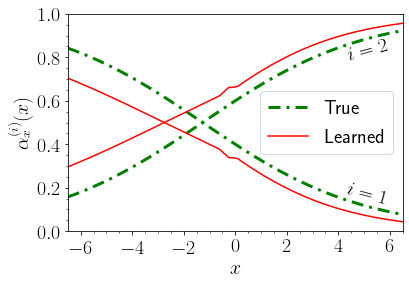

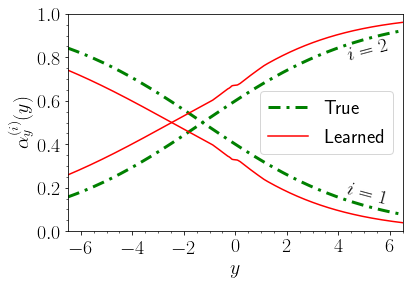

In [13]:
def plot_format(ax):
    ax.set_xticks(range(-6, 7, 2))
    ax.set_xlim(-6.5, 6.5)
    ax.set_ylim(0, 1)
    ax.legend(loc=5)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.text(6, .17, r"$i=1$", rotation=-15, ha='right', va='center')
    ax.text(6, .83, r"$i=2$", rotation=+15, ha='right', va='center')

x = np.linspace(-6.5, 6.5, 1000)
raw_x_classifier_output = model_x.predict(x)
balanced_x_classifier_output = inclass_utils.get_balanced_single_classifier_output(y_pred_variate=raw_x_classifier_output,
                                                                                   pseudo_weights_variate=model_postprocess['pseudo_weights'][0], 
                                                                                   weights=model_postprocess['norm_weights'])

y = np.linspace(-6.5, 6.5, 1000)
raw_y_classifier_output = model_y.predict(y)
balanced_y_classifier_output = inclass_utils.get_balanced_single_classifier_output(y_pred_variate=raw_y_classifier_output,
                                                                                   pseudo_weights_variate=model_postprocess['pseudo_weights'][1], 
                                                                                   weights=model_postprocess['norm_weights'])

fig, ax = plt.subplots()
ax.plot(x, comp_1_classify_x(x), color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(x, comp_2_classify_x(x), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(x, balanced_x_classifier_output[:,0], color='red', label='Learned')
ax.plot(x, balanced_x_classifier_output[:,1], color='red')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\alpha^{(i)}_x(x)$')
plot_format(ax)
plt.savefig(figname('classifier_x.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(y, comp_1_classify_y(y), color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(y, comp_2_classify_y(y), color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(y, balanced_y_classifier_output[:,0], color='red', label='Learned')
ax.plot(y, balanced_y_classifier_output[:,1], color='red')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$\alpha^{(i)}_y(y)$')
plot_format(ax)
plt.savefig(figname('classifier_y.pdf'), bbox_inches='tight')

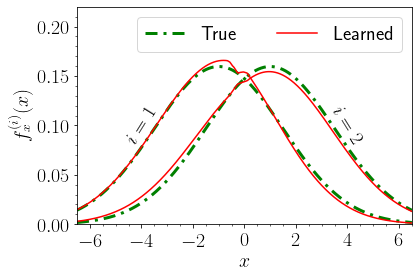

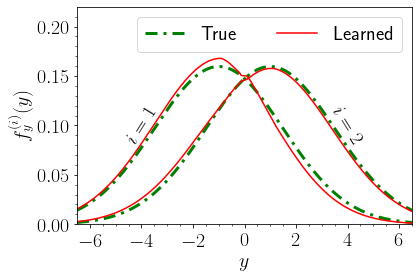

In [14]:
def plot_format(ax):
    ax.set_xticks(range(-6, 7, 2))
    ax.set_xlim(-6.5, 6.5)
    ax.set_ylim(0, .22)
    ax.legend(ncol=2)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.text(-4, .1, r"$i=1$", ha='center', va='center', rotation=58)
    ax.text(4, .1, r"$i=2$", ha='center', va='center', rotation=-58)

fig, ax = plt.subplots()
ax.plot(x, x_pdf(x)*comp_1_classify_x(x)/w_1, color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(x, x_pdf(x)*comp_2_classify_x(x)/w_2, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(x, x_pdf(x)*balanced_x_classifier_output[:,0]/model_postprocess['norm_weights'][0], color='red', label='Learned')
ax.plot(x, x_pdf(x)*balanced_x_classifier_output[:,1]/model_postprocess['norm_weights'][1], color='red')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f^{(i)}_x(x)$')
plot_format(ax)
plt.savefig(figname('compdist_x.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(y, y_pdf(y)*comp_1_classify_y(y)/w_1, color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
ax.plot(y, y_pdf(y)*comp_2_classify_y(y)/w_2, color='green', linestyle=(0, (4,2,1,2)), linewidth=3)
ax.plot(y, y_pdf(y)*balanced_y_classifier_output[:,0]/model_postprocess['norm_weights'][0], color='red', label='Learned')
ax.plot(y, y_pdf(y)*balanced_y_classifier_output[:,1]/model_postprocess['norm_weights'][1], color='red')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$f^{(i)}_y(y)$')
plot_format(ax)
plt.savefig(figname('compdist_y.pdf'), bbox_inches='tight')

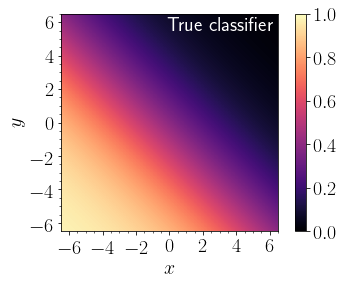

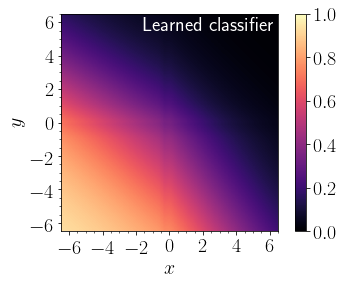

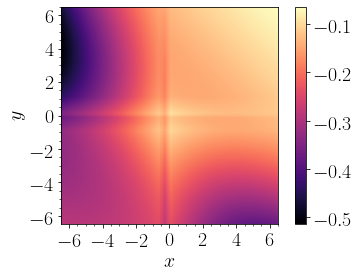

In [15]:
def plot_format(ax):
    ax.set_aspect('equal')
    ax.set_xticks(range(-6, 7, 2))
    ax.set_xlim(-6.5, 6.5)
    ax.set_yticks(range(-6, 7, 2))
    ax.set_ylim(-6.5, 6.5)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.linspace(-6.5, 6.5, 500)
y = np.linspace(-6.5, 6.5, 500)
x, y = np.meshgrid(x, y)

x_shape_cache = x.shape
y_shape_cache = y.shape

x = x.reshape((-1,))
y = y.reshape((-1,))

to_plot_true = true_aggregate_classifier([x, y])[:,0].reshape(x_shape_cache)

raw_classifier_outputs = inclass_model.predict([x, y])
aggregate_classifier_output = inclass_utils.get_aggregate_classifier_output(raw_classifier_outputs,
                                                                           pseudo_weights=model_postprocess['pseudo_weights'])
to_plot_learned = aggregate_classifier_output[:,0].reshape(x_shape_cache)
err = (to_plot_learned-to_plot_true) / np.sqrt(to_plot_true * (1-to_plot_true))

x = x.reshape(x_shape_cache)
y = y.reshape(y_shape_cache)

fig, ax = plt.subplots()
_ = ax.pcolormesh(x, y, to_plot_true, rasterized=True, cmap=cmap, vmin=0, vmax=1)
plot_format(ax)
ax.text(6.3, 5.8, "True classifier", ha='right', va='center', color='white')
plt.colorbar(_)
plt.savefig(figname('aggregate_true.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
_ = ax.pcolormesh(x, y, to_plot_learned, rasterized=True, cmap=cmap, vmin=0, vmax=1)
plot_format(ax)
ax.text(6.3, 5.8, "Learned classifier", ha='right', va='center', color='white')
plt.colorbar(_)
plt.savefig(figname('aggregate_learned.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
_ = ax.pcolormesh(x, y, err, rasterized=True, cmap=cmap)
plot_format(ax)
plt.colorbar(_)
plt.savefig(figname('aggregate_err.pdf'), bbox_inches='tight')